# INTRODUCTION TO RECOMMENDER SYSTEMS

This notebook accompanies the lecture **Introduction to Recommender Systems** that I gave in August 2023 to **the Data Science School: Industry Engagement and Applications** organized by **Department of Statistics of the University of Lagos and Statistics Without Borders**.

The main goal of this notebook is to provide the scripts that I used to generate images and examples presented in the slides (see [github](https://github.com/lucaalbrizzo/introduction-reco-lagos) ), along with some additional material that might be interesting for those who attended the lecture.


I take advantage of this notebook to thank the organizers of this school, in particular Rose Ray and Kusharga Sharma who helped me prepare this presentation. 

# LIBRARIES INSTALLATION

All the code used in this notebook was generated using Python 3.10 which can be found download [here](https://www.python.org/downloads/) (note that if you are using Unix, Python is pre-installed).

Along with standalone Python, this notebook requires some additional libraries that can be installed using [pip](https://pip.pypa.io/en/stable/installation/) (just run the next cell or  use the requirements.txt file).

In [5]:
!pip install numpy 
!pip install matplotlib
!pip install seaborn
!pip install surprise
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


The installed libraries are:

- [numpy](https://numpy.org/): the fundamental library for scientific computing;
- [Matplotlib](https://matplotlib.org/) a library for creating static, animated, and interactive visualizations;
- [Seaborn](https://seaborn.pydata.org/) a library which adds more functionality to matplotlib;
- [Pandas](https://pandas.pydata.org/): the most used Python data manipulation library;
- [Surprise](https://surpriselib.com/): a Python for building and analyzing recommender systems, which is used here to present some recommender algorithms.

Let's import these libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from surprise import Dataset, NMF, KNNBasic
from surprise.model_selection import cross_validate

plt.style.use('ggplot') #use ggplot (based on grammar of graphics)

## MovieLens Dataset

The [Movielens dataset](https://grouplens.org/datasets/movielens/) is presented in section 4 of the presentation and could be easily downloaded (2 versions 100k and 1M users) and used via the [Dataset module](https://surprise.readthedocs.io/en/stable/dataset.html) of the Surprise library.

In [3]:
data_100k = Dataset.load_builtin('ml-100k')

data_1M = Dataset.load_builtin('ml-1m') #this might take some time

The Suprise library will ask the user if they want to download and then save the datasets at **/home/user/.surprise_data**.


Since the 1M dataset is saved in the **.dat** format to save some space, it requires some manipulation to be easily explored.

In [30]:
#reading users dataset
unames = ['user_id', 'gender', 'age', 'occupation', 'zip']
users = pd.read_table('/home/lumaca/.surprise_data/ml-1m/ml-1m/users.dat', sep='::',
 header=None, names=unames, engine='python', encoding='latin-1')
#reading rating dataset
rnames = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_table('/home/lumaca/.surprise_data/ml-1m/ml-1m/ratings.dat', sep='::',
 header=None, names=rnames, engine='python', encoding='latin-1')
#reading movies dataset
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('/home/lumaca/.surprise_data/ml-1m/ml-1m/movies.dat', sep='::',
 header=None, names=mnames, engine='python', encoding='latin-1')

In [31]:
#addina a column for genre, using the first genre for each film for simplicity
movies['genres'] = [genre.split("|")[0] for genre in movies['genres'].tolist()]

In [19]:
# Organise a bit and store into feather-format
movies.sort_values(by='movie_id', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.sort_values(by='movie_id', inplace=True)
ratings.reset_index(inplace=True, drop=True)



# Modify rating timestamp format (from seconds to datetime year)
#ratings.timestamp = pd.to_datetime(ratings.timestamp, unit='s')
ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)
ratings.timestamp = ratings.timestamp.dt.year

# Check and clean NaN values
print ("Number of movies Null values: ", max(movies.isnull().sum()))
print ("Number of ratings Null values: ", max(ratings.isnull().sum()))
movies.dropna(inplace=True)
ratings.dropna(inplace=True)
    
# Organise a bit, then save into feather-formatand clear from memory
movies.sort_values(by='movie_id', inplace=True)
ratings.sort_values(by='movie_id', inplace=True)
movies.reset_index(inplace=True, drop=True)
ratings.reset_index(inplace=True, drop=True)

Number of movies Null values:  0.0
Number of ratings Null values:  0


/tmp/ipykernel_103929/1914939187.py:15: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  ratings.timestamp = pd.to_datetime(ratings.timestamp, infer_datetime_format=True)


In [32]:
# Let's define a year column by converting the timestamp
movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
movies.year = pd.to_datetime(movies.year, format='%Y')
movies.year = movies.year.dt.year # As there are some NaN years, resulting type will be float (decimals)
movies.title = movies.title.str[:-7]

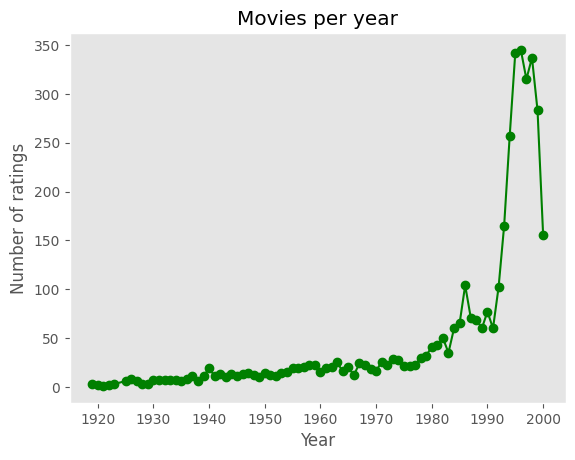

In [33]:
dftmp = movies[['movie_id', 'year']].groupby('year')

plt.plot(dftmp.year.first(), dftmp.movie_id.nunique(), "g-o")
plt.grid(None)

plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.ylabel('Number of ratings')
plt.title('Movies per year')
plt.show()


As we can see, the Movielens contains ratings for movies released as early as the 1920(!) with a prevalence of movies from the '90s (which can be explained by the popularity of this service in the early 2000s).

([<matplotlib.axis.XTick at 0x7f5d972684c0>,
 [Text(1.0, 0, '1'),
  Text(1.8, 0, '2'),
  Text(2.6, 0, '3'),
  Text(3.4, 0, '4'),
  Text(4.2, 0, '5')])

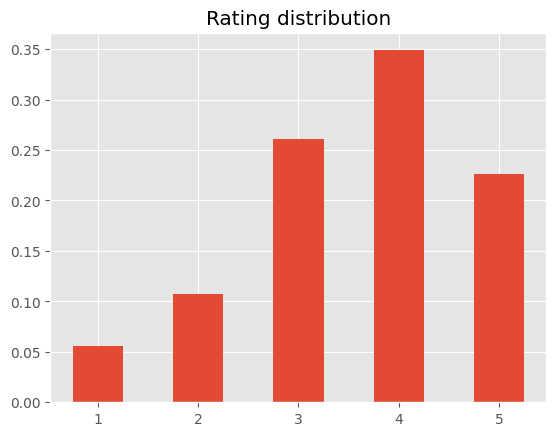

In [146]:
hist, bins = np.histogram(ratings['rating'], bins=5)
plt.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0])/2.0)
plt.title('Rating distribution')
plt.xticks([1,1.8,2.6,3.4,4.2], ('1', '2', '3', '4', '5'))

Ratings are not equally distributed, which is one of the main problems of building a recommender system (slide 6).

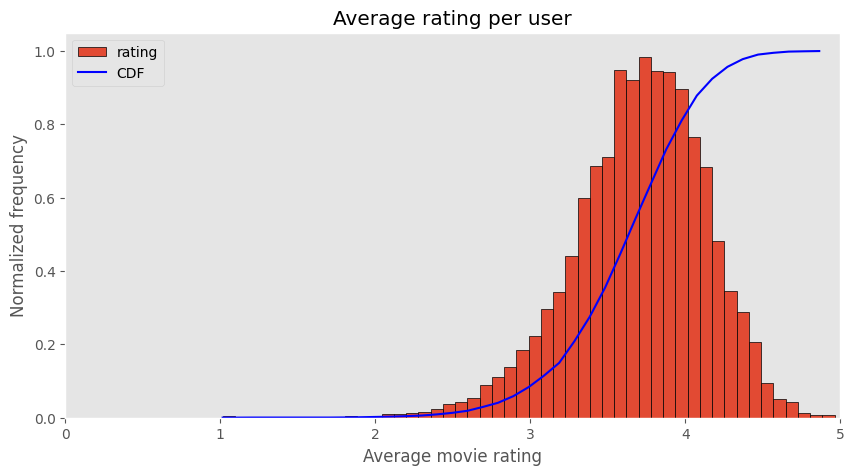

In [40]:
dftmp = ratings[['user_id','rating']].groupby('user_id').mean()
# Plot histogram
dftmp.plot(kind='hist', bins=50, grid=0, density=True, edgecolor='black', figsize=(10,5))
# Plot cumulative function on top (couldn't do any other way)
# evaluate the histogram
values, base = np.histogram(dftmp, bins=40, density=True)
# evaluate the cumulative (multiply by the average distance between points in the x-axis to get UNIT area)
cumulative = np.cumsum(values) * np.diff(base).mean()
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label='CDF')
plt.xlim(0,5)
plt.legend()
plt.xlabel ('Average movie rating')
plt.ylabel ('Normalized frequency')
plt.title ('Average rating per user')
plt.show()

Moreover, the average user is positively biased (they rate more often movies that they like) which might make our recommender system overestimate ratings. 

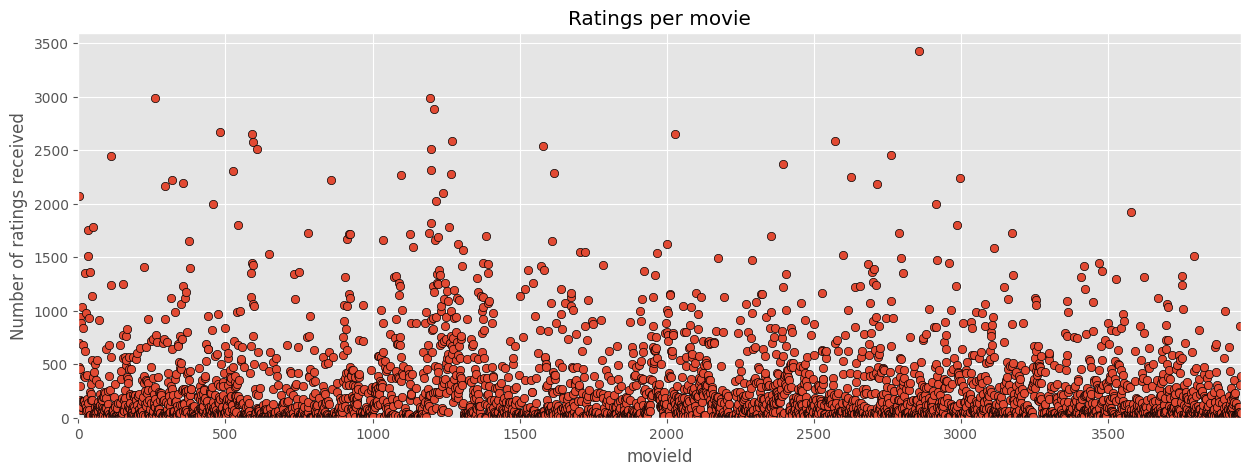

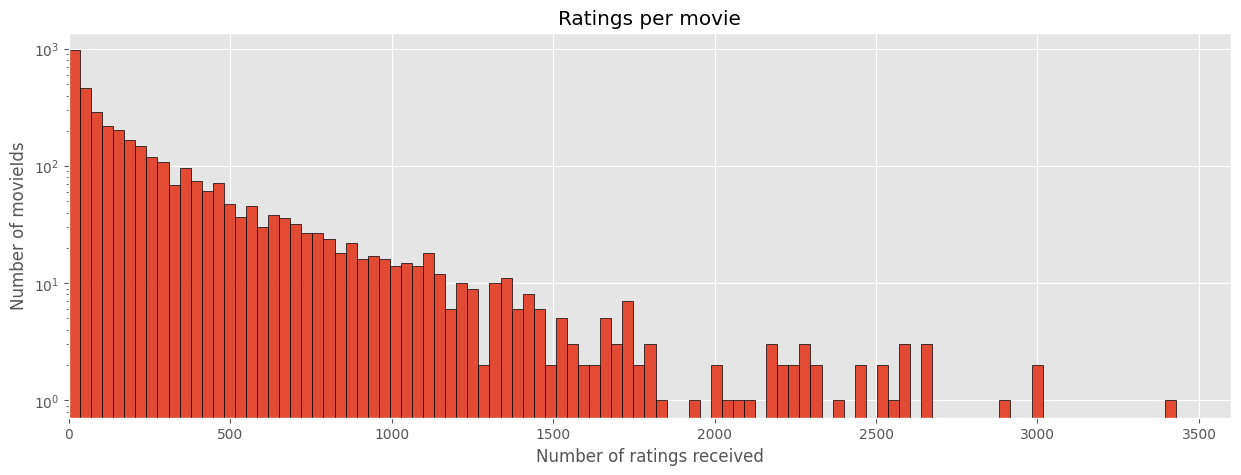

In [154]:
# Scatter plot of all users and individual ratings count.
dftmp = ratings[['user_id', 'movie_id']].groupby('movie_id').count()
dftmp.columns=['num_ratings']
plt.figure(figsize=(15,5))
plt.scatter(dftmp.index, dftmp.num_ratings, edgecolor='black')
plt.xlim(0,dftmp.index.max())
plt.ylim(0,)
plt.title('Ratings per movie')
plt.xlabel('movieId')
plt.ylabel('Number of ratings received')
plt.show()

# Histogram of ratings counts.
plt.figure(figsize=(15,5))
plt.hist(dftmp.num_ratings, bins=100, edgecolor='black', log=True)
plt.title('Ratings per movie')
plt.xlabel('Number of ratings received')
plt.ylabel('Number of movieIds')
plt.xlim(0,)
plt.show()

# User item matrix sparsity

One common way to represent the rating data is to construct a user-item matrix, i.e. a matrix with users as columns, items (e.g. movies) as rows and each entry represents a rating (see slide 16 for more details).


As anticipated above and in the slides, one of the main problems of modern RecSys is the high sparsity of the data due to the fact that only a small fraction of users rate a small fractions of items.

In this section, we will compute and visualize the sparsity of the user-item matrix, limiting ourselves to 100k dataset to avoid long calculations and visualizations that are hard to interpret.

However, it must be noted that all the issues related to sparsity that I present here get increasingly worse as the dataset size grows, since the number of possible user-movies combinations grows as $N_{u} \times N_{i}$.


Let us now load the 100k Movielens dataset with pandas and transform it in user-item matrix

In [7]:
data_df = pd.read_csv('/home/lumaca/.surprise_data/ml-100k/ml-100k/u.data', sep = '\t', names = ['user_id','item_id','rating','timestamp'])
data_df['user_id'] = pd.factorize(data_df['user_id'])[0] #factorize reindexes the series with number from 0 to N_u
data_df['item_id'] = pd.factorize(data_df['item_id'])[0]
data_df

,user_id,item_id,rating,timestamp
0,0,0,3,881250949
1,1,1,3,891717742
2,2,2,1,878887116
3,3,3,2,880606923
4,4,4,1,886397596
...,...,...,...,...
99995,875,173,3,880175444
99996,708,247,5,879795543
99997,37,1004,1,874795795
99998,58,443,2,882399156


In [8]:
user_ids = np.arange(len(data_df['user_id'].unique())) #compute the unique user ids
item_ids = np.arange(len(data_df['item_id'].unique())) #compute the unique item ids

Let us compute the matrix ranking, by scanning the entire dataset for each movies and filling a row entry each time a user rated a movie:

In [9]:


matrix_ranking = []


for user in user_ids:
    ui_vec = np.zeros(len(item_ids))
    for item in item_ids:
        df_user_item = data_df[(data_df['user_id']==user) &  (data_df['item_id']==item)]['rating']
        if df_user_item.empty is True:
            ui_vec[item]=np.nan
        else:
            ui_vec[item] = df_user_item.values[0]
    np.random.shuffle(ui_vec)
    matrix_ranking.append(ui_vec)

In [10]:
matrix_ranking[0:5] # the first five rows of the matrix, we can already guess it is going to be very sparse

[array([nan, nan, nan, ..., nan, nan,  5.]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan,  5., nan]),
 array([nan,  3., nan, ..., nan, nan,  3.]),
 array([nan, nan, nan, ..., nan, nan, nan])]

Given the matrix $M_{u,m}$ computed above, we can compute its sparsity simply as:

\begin{equation}
S(M_{u,i}) = \frac{N_{\varnothing }}{N_i \times N_u}
\end{equation} 

where $N_{\varnothing }$ is the number of non-zero elements in the matrix.

$S(M_{u,i})$ can be computed easily in Python as

In [11]:
sparsity = len(~np.isnan(matrix_ranking)) / (len(user_ids)*len(item_ids))
print(np.round(sparsity, 4))

0.0006


Which tells us only around $0.06$ % of the matrix is non-zero!

This can also be visualized by printing the matrix as as a heatmap (with ratings color coded in such a way that 1 is red and 5 is green):

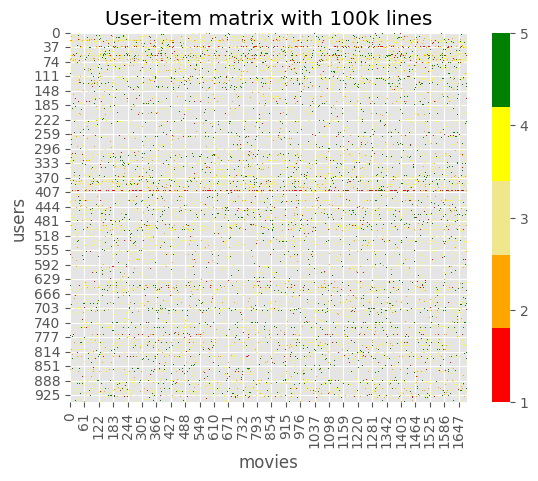

In [12]:
import matplotlib.colors as c

colors = {"red":1, "orange":2, "khaki":3, "yellow":4, "green":5}

l_colors = sorted(colors, key=colors.get)
cMap = c.ListedColormap(l_colors)

#plt.axis('off') # if you don't want the axis
sns.heatmap(matrix_ranking,cmap=cMap, cbar_kws={'ticks': [1,2,3,4,5]})
plt.xlabel('movies')
plt.ylabel('users')

plt.title("User-item matrix with 100k lines")
plt.show()

which helps visualize how low the sparsity of this matrix.

## RECOMMENDER SYSTEMS WITH SURPRISE

Let us now use the [Suprise library](https://surpriselib.com/) to compare the performances of two classic RecSys algorithms, namely KNN and Matrix factorization (slide 14 and 16), on the 100k and 1M datasets. 

Using the Suprise library, it is very easy to load these two algorithms and datasets (see below):

In [4]:
algo_NMF = NMF()

algo_KNN = KNNBasic()


#data_100k = Dataset.load_builtin('ml-100k') #commented to not reload again

#data_1M = Dataset.load_builtin('ml-1m') #commented to not reload again

Suprise allows the user to perform a cross validation on a dataset with a one liner for both algorithms:

In [171]:
cross_validate(algo_KNN, data_100k, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9766  0.9843  0.9763  0.9755  0.9762  0.9778  0.0033  
MAE (testset)     0.7719  0.7766  0.7714  0.7710  0.7704  0.7723  0.0022  
Fit time          0.52    0.61    0.55    0.65    0.64    0.59    0.05    
Test time         3.87    3.98    4.13    4.96    3.78    4.15    0.42    


{'test_rmse': array([0.97662735, 0.98432238, 0.97627429, 0.97550287, 0.97621482]),
 'test_mae': array([0.77189394, 0.77656272, 0.77136233, 0.77101972, 0.77042628]),
 'fit_time': (0.5200009346008301,
  0.6062014102935791,
  0.5545375347137451,
  0.6502087116241455,
  0.6370444297790527),
 'test_time': (3.8733389377593994,
  3.9802072048187256,
  4.12854528427124,
  4.963423490524292,
  3.784580945968628)}

In [172]:
cross_validate(algo_NMF, data_100k, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9531  0.9585  0.9656  0.9644  0.9581  0.9599  0.0046  
MAE (testset)     0.7471  0.7547  0.7578  0.7560  0.7545  0.7540  0.0036  
Fit time          2.47    2.48    2.50    2.41    1.92    2.35    0.22    
Test time         0.12    0.13    0.11    0.10    0.08    0.11    0.02    


{'test_rmse': array([0.95307855, 0.95851566, 0.96557373, 0.96435749, 0.95808934]),
 'test_mae': array([0.74714608, 0.75467607, 0.75776697, 0.75595138, 0.75452384]),
 'fit_time': (2.469280242919922,
  2.4761130809783936,
  2.499408721923828,
  2.4068050384521484,
  1.9206912517547607),
 'test_time': (0.11892390251159668,
  0.12717080116271973,
  0.11408185958862305,
  0.10313081741333008,
  0.08129692077636719)}

In which we can see that the RSME for the two algorithms are similar (a small advantage for KNN). However, KNN has much shorter fit time and much longer test time compared to NMF, which might be a good or bad depending on the applications (e.g. we might need less latency).


Let us now repeat the same experiments with the 1M dataset (go grab a coffee/tea this will take some time :) ):

In [5]:
cross_validate(algo_KNN, data_1M, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9226  0.9237  0.9227  0.9240  0.9218  0.9229  0.0008  
MAE (testset)     0.7265  0.7279  0.7286  0.7275  0.7272  0.7275  0.0007  
Fit time          34.05   25.88   25.29   24.75   24.83   26.96   3.57    
Test time         106.69  91.38   90.23   91.25   95.48   95.00   6.11    


{'test_rmse': array([0.92258469, 0.9236685 , 0.92271737, 0.92397536, 0.92175887]),
 'test_mae': array([0.72651975, 0.72788549, 0.72855611, 0.72749231, 0.72716   ]),
 'fit_time': (34.049357891082764,
  25.876004934310913,
  25.291017770767212,
  24.74731731414795,
  24.826032638549805),
 'test_time': (106.68905687332153,
  91.37564063072205,
  90.23176407814026,
  91.25290656089783,
  95.47533369064331)}

In [6]:
cross_validate(algo_NMF, data_1M, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9185  0.9172  0.9146  0.9131  0.9189  0.9164  0.0022  
MAE (testset)     0.7252  0.7250  0.7227  0.7224  0.7258  0.7242  0.0014  
Fit time          13.94   13.93   13.98   14.02   14.16   14.01   0.08    
Test time         1.66    1.63    1.37    1.38    1.62    1.53    0.13    


{'test_rmse': array([0.91845393, 0.91715449, 0.91455357, 0.91310355, 0.91886527]),
 'test_mae': array([0.72521561, 0.72496126, 0.72273422, 0.72244382, 0.72584976]),
 'fit_time': (13.93899941444397,
  13.932493925094604,
  13.9817533493042,
  14.019038200378418,
  14.161362886428833),
 'test_time': (1.6568877696990967,
  1.6298213005065918,
  1.3723995685577393,
  1.3779914379119873,
  1.615053415298462)}

which shows that NMF has much better performances (same RSME but vastly inferior fit and test time) than KNN for large and very sparse datasets, as shown in the presentation.


# CONCLUSIONS


 - Modern RecSys are powerful but suffer from some problems, such as sparsity, cold start …

- Collaborative filtering is based on the idea of using other user’s information

- KNN based algorithm are useful but do not scale well

- MF is the “golden standard” of RecSys as it scales well and it is designed for sparse data